<div style="display: flex; background-color: #b24c31;" >
<h1 style="margin: auto; padding: 30px; ">ACP ET CLUSTERING - LA POULE QUI CHANTE</h1>
</div>

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
import seaborn as sns
warnings.simplefilter(action='ignore', category=UserWarning)

<div style="display: flex; background-color: #b67356;" >
<h1 style="margin: auto; padding: 26px; ">1. Importations du dataframe</h1>
</div>

In [2]:
path ="C:\\Users\\yannf\\Desktop\\Cours\\Formation_data_analyse\\projets\\projet_11\\input\\"
main_df = "DAN-P9-data\\main_df.csv"
df = pd.read_csv(f"{path}\\{main_df}", sep=",")
df = df.set_index("country", drop=True)

In [3]:
df.head()

,Production,Annual growth US$ per capita,Value US$ per capita,infla_var,Undernourish%,Import_export%,pop_2018,percent_var_pop,Healthy_diet,clearance,logistic_quality
country,,,,,,,,,,,
Albania,2.267394,16.572567,5230.404883,10.198559,4.2,18.0,14.878230,-0.151830,0.881984,2.347126,2.558898
Algeria,2.524284,0.856630,4017.477431,12.253368,2.0,22.0,17.565133,6.210733,0.901241,2.130280,2.391247
Angola,2.363702,-19.824847,2973.918724,97.919955,15.7,7.0,17.259038,11.149157,0.975202,1.571429,2.004317
Armenia,2.242554,8.257530,4356.255071,3.130555,2.0,25.0,14.883652,-0.383818,0.950841,2.573787,2.503441
Australia,2.638512,1.462323,55971.295459,2.394210,2.0,5.0,17.039163,4.892700,0.797713,3.867186,3.709445


<div style="display: flex; background-color: #b0280a;" >
<h1 style="margin: auto; padding: 18px; ">Debut de l'ACP</h1>
</div>

In [4]:
'''Function to display the correlation circle'''
def correlation_graph(pca, axis, names, percent) : 
    x,y=axis
    fig, ax = plt.subplots(figsize=(10, 9))
    #Iterate by component
    for i in range(0, len(names)):
        #creating the arrows
        #we keep only the value >0.05 (abs) to only analyze the relevant indicators
        if (abs(pca.components_[x, i]) >=percent and abs(pca.components_[y, i])>=percent): 
            ax.arrow(0,0, pca.components_[x, i], pca.components_[y, i],  
                    head_width=0.06, head_length=0.06, width=0.012,ec ="black", color="#44c1dd", alpha=0.6)
    
            # Adding legends to the arrows
            
            plt.text(pca.components_[x, i] + 0.05, pca.components_[y, i] + 0.05, names[i], c="red")
        
    #Displaying horizontal and vertical lines
    plt.plot([-1, 1], [0, 0], color='#acbcbf', ls='--')
    plt.plot([0, 0], [-1, 1], color='#acbcbf', ls='--')

    #Display inertia percentage next to the axis name
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    #set up the title
    plt.title(f"Correlation circle for F{x+1} and  F{y+1}")

    #Plot the circle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    plt.axis('equal')
    plt.show()

In [5]:
'''Function to project the values from our PCA on the plan formed by the selected components'''
def display_factorial_planes(val_projected, axis, pca=None, labels = None, clusters=None, alpha=0.8, figsize=[10,8], marker="x", index=None):
    # Transforme val_projected en np.array
    X_ = np.array(val_projected)

    #Remove to display the country corresponding to the index using a mask
    if index :
        mask = np.ones(len(X_), dtype=bool) #set a mask for our values
        mask[index] = False
        X_ = X_[mask]
        labels = np.array(labels)
        labels = labels[mask]

    #Default figsize if value is missing
    if not figsize: 
        figsize = (7,6)
        
    #Handling missing labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    #Checking if we provide 2 component in axis variables 
    if not len(axis) ==2 : 
        raise AttributeError("2 axis needed")   
    if max(axis)>= X_.shape[1] : 
        raise AttributeError("The component doesnt have the shape as the array")   

    x, y = axis     
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    #Checking if we provide clusters
    clu = [] if clusters is None else clusters
    # if 
    if len(clu) >0 :
        #Using plt or sns to display it 
        scatter = plt.scatter(X_[:, x], X_[:, y], alpha=alpha, 
                            c=clu, cmap="Set1", marker=marker)
        # sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)
        handles, values = scatter.legend_elements(alpha=0.6)
        legend2 = ax.legend(handles, values, loc="upper right", title="Clusters")
    else :
        plt.scatter(X_[:, x], X_[:, y], alpha=alpha, cmap="Set1", marker=marker)
    # Calculate the % variance explained if PCA is provided
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    #Display inertia percentage next to the axis name
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    #Creating variable for the max value on both axis (to define the max for each of them)
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    #Displaying horizontal and vertical lines using the max values
    plt.plot([-x_max, x_max], [0, 0], color='#acbcbf', alpha=0.6)
    plt.plot([0,0], [-y_max, y_max], color='#acbcbf', alpha=0.6)

    #Placing each country next to his marker
    '''Actually harder to visualize with labels on'''
    if len(labels) :
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='8', ha='center',va='center') 

    # plt.title(f"Projecting country on the component F{x+1} and F{y+1}")
    
    plt.show()

In [6]:
'''We select a high number of components to display the explained variance chart and choose the last component
that explain at least 100/n % of the variance where n is the original number of indicators'''

#We split the values and the columns name
val = df.values
names_col = df.columns
n_components = 10

#We can proceed to the PCA
pca = PCA(n_components=n_components)

#we create an instance of our scaler
scaler = StandardScaler()

#We transform into centred reduce the values
val_scaled = scaler.fit_transform(val)
pca.fit(val_scaled)

df_explain_var = pd.DataFrame([[f"{round(w*100, 2)}%" for w in pca.explained_variance_ratio_]], columns=[f"F{x}" for x in range(1,n_components+1)])
print(df_explain_var)
print(f"Le minimum de variance expliquée nécessaire est de {round(100/len(df.columns) ,2)}%")
'''Nous allons donc choisir d'utiliser 4 composantes.'''

       F1      F2      F3     F4     F5     F6     F7     F8     F9    F10
0  40.31%  19.17%  12.89%  8.73%  6.99%  3.66%  2.81%  2.31%  1.36%  1.29%
Le minimum de variance expliquée nécessaire est de 9.09%


"Nous allons donc choisir d'utiliser 4 composantes."

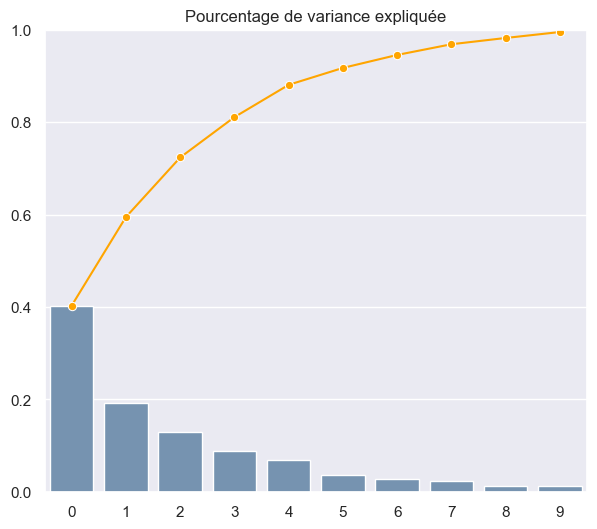

'We can see that the explained variance start decreasing significantly slower from the 4th components'

In [7]:
#We can confirm our choice with this chart (éboulis des valeurs propres)
cumsum_comp = pca.explained_variance_ratio_.cumsum()

sns.set_theme(rc={'figure.figsize':(7,6)})
sns.lineplot(cumsum_comp, color="orange", dashes =True, marker="o")
sns.barplot(pca.explained_variance_ratio_, color="#6d93b9")
plt.ylim(0,1)
plt.title("Pourcentage de variance expliquée")
plt.show()
df_exp_var = pd.DataFrame(pca.explained_variance_ratio_)
'''We can see that the explained variance start decreasing significantly slower from the 4th components'''

'We can see that from the 5th and 6th components both have a really high correlation with almost only one indicator.\nThat means those components will not be really relevant to take into account (Doesnt add much informations)'

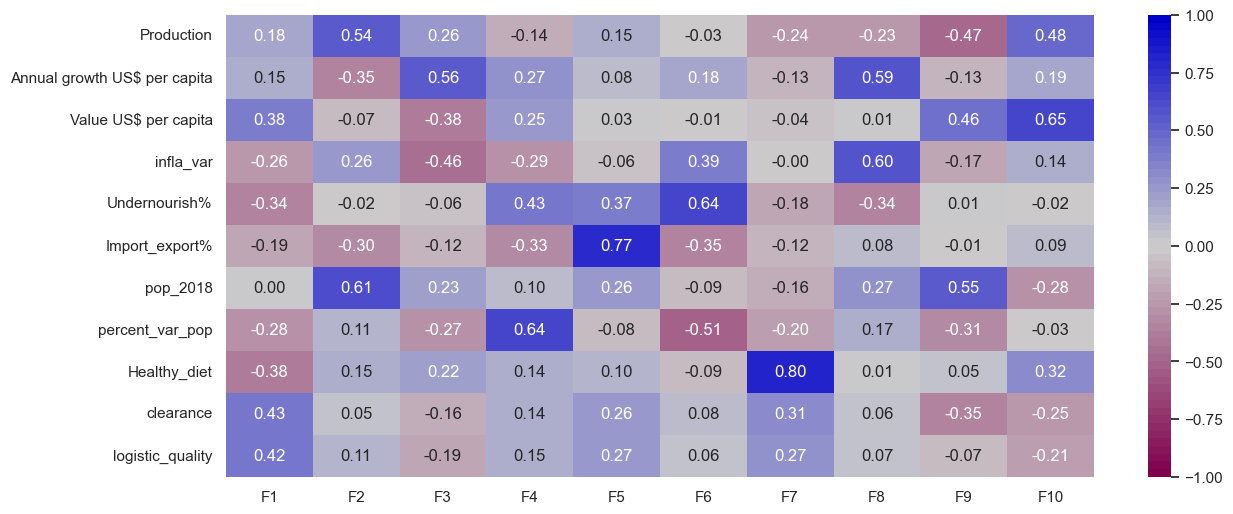

In [8]:
#Another way to confirm our result is by consulting the correlation between the components and each indicators

#Creating a dataframe with our components as values and the indicators as columns
cmp = pd.DataFrame(pca.components_,columns = names_col, index=[f"F{x}" for x in list(range(1,n_components+1))])
#we transpose the dataframe and display a correlation heatmap
cmp = cmp.T
colors = [(0.5, 0, 0.3), (0.8, 0.8, 0.8), (0, 0, 0.8)]  # Maroon / Grey / Blue
bins = 60
cmap_name = 'maroon_blue'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=bins)
fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(cmp, vmin=-1, vmax=1, annot=True, cmap=cmap, fmt="0.2f")
'''We can see that from the 5th and 6th components both have a really high correlation with almost only one indicator.
That means those components will not be really relevant to take into account (Doesnt add much informations)'''

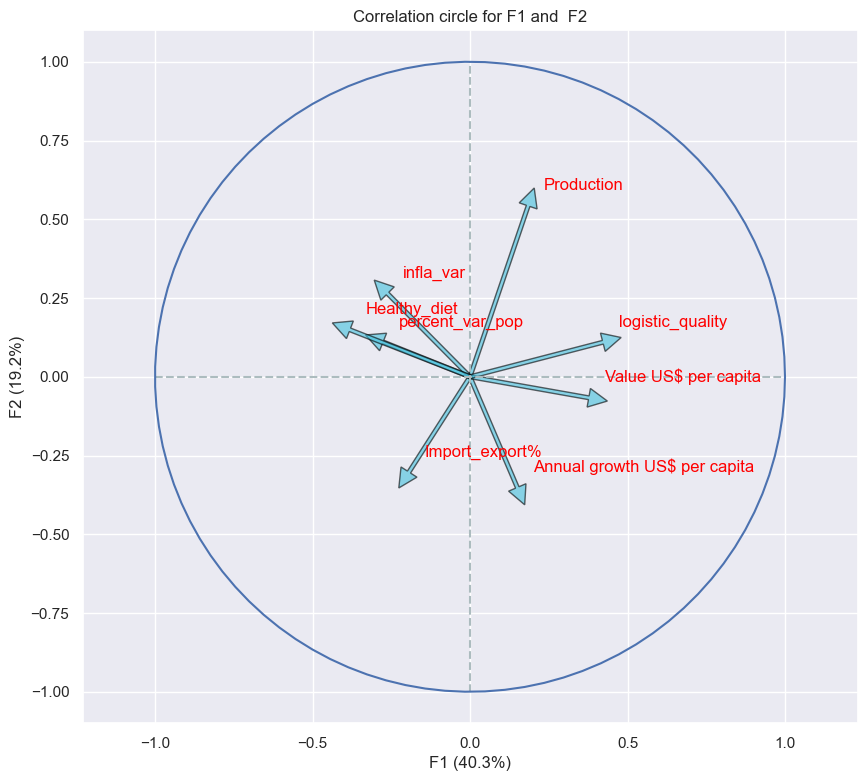

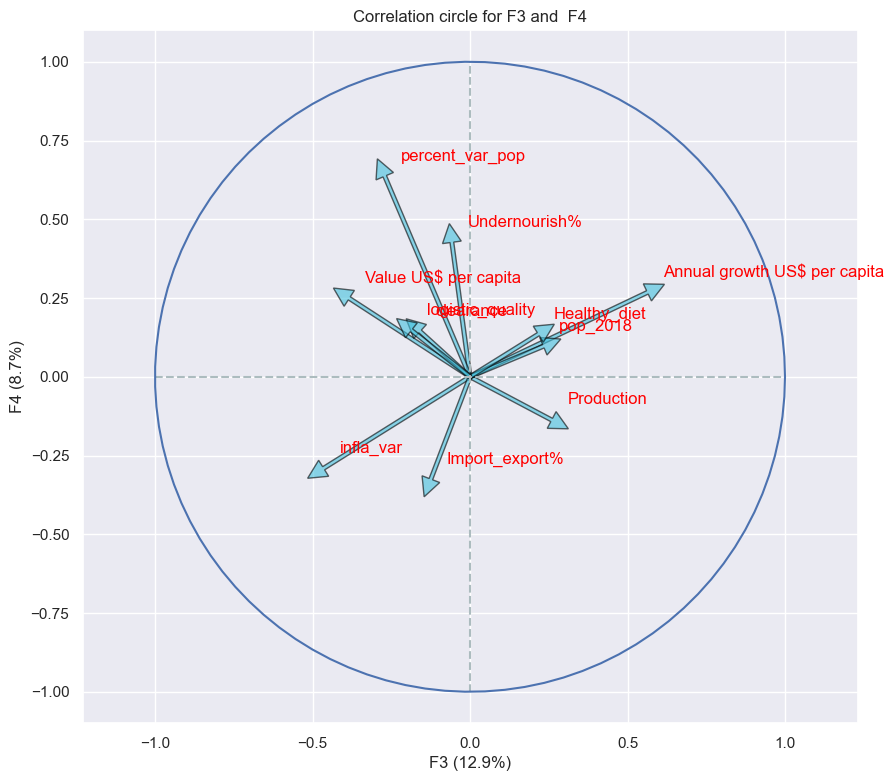

In [9]:
#Proceed to PCA with 4 components and display both pairs of components plan
n_components = 4
pca = PCA(n_components=n_components)
pca.fit(val_scaled)

#Adding a percent parameter to display only arrow with a significant value (here 10%)
correlation_graph(pca, (0,1), names_col, percent=0.05)
correlation_graph(pca, (2,3), names_col, percent=0.05)

In [10]:
#we can then recalculate the coordinate of our values (that now have the origin as start) 
n_components = 4
pca = PCA(n_components=n_components)
pca.fit(val_scaled)
val_projection = pca.transform(val_scaled)

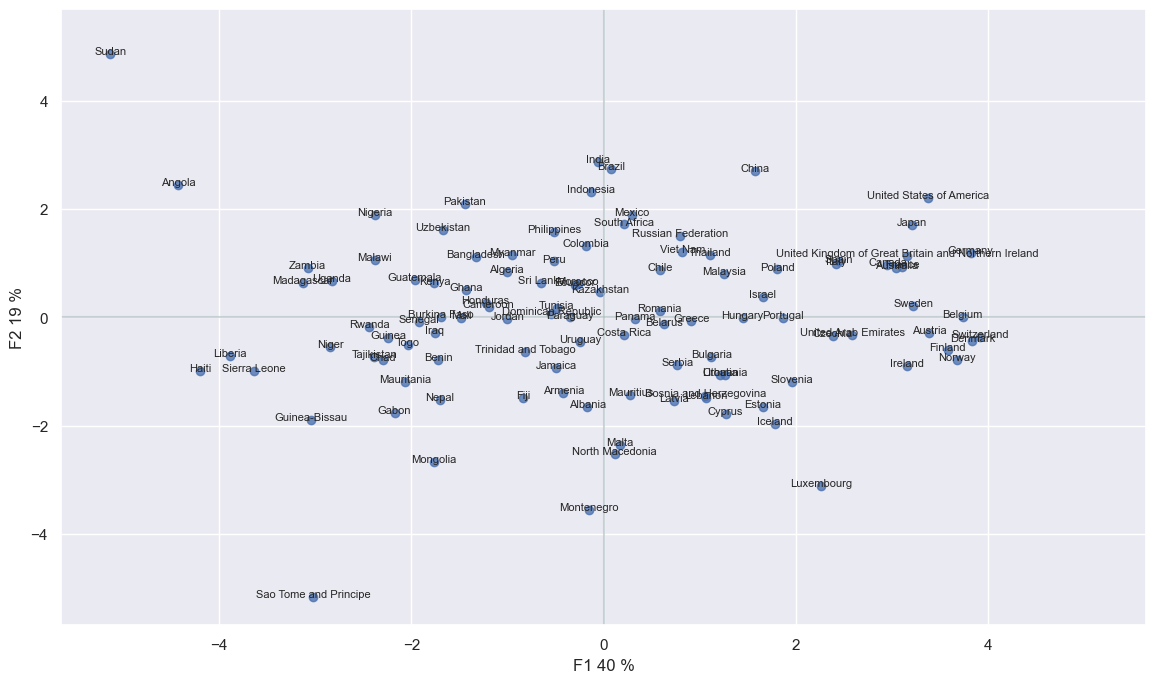

In [11]:
#Components F1/F2 representation
names = df.index
axis = [0,1]
display_factorial_planes(val_projection, axis, pca, labels=names, figsize=(14,8), marker="o")

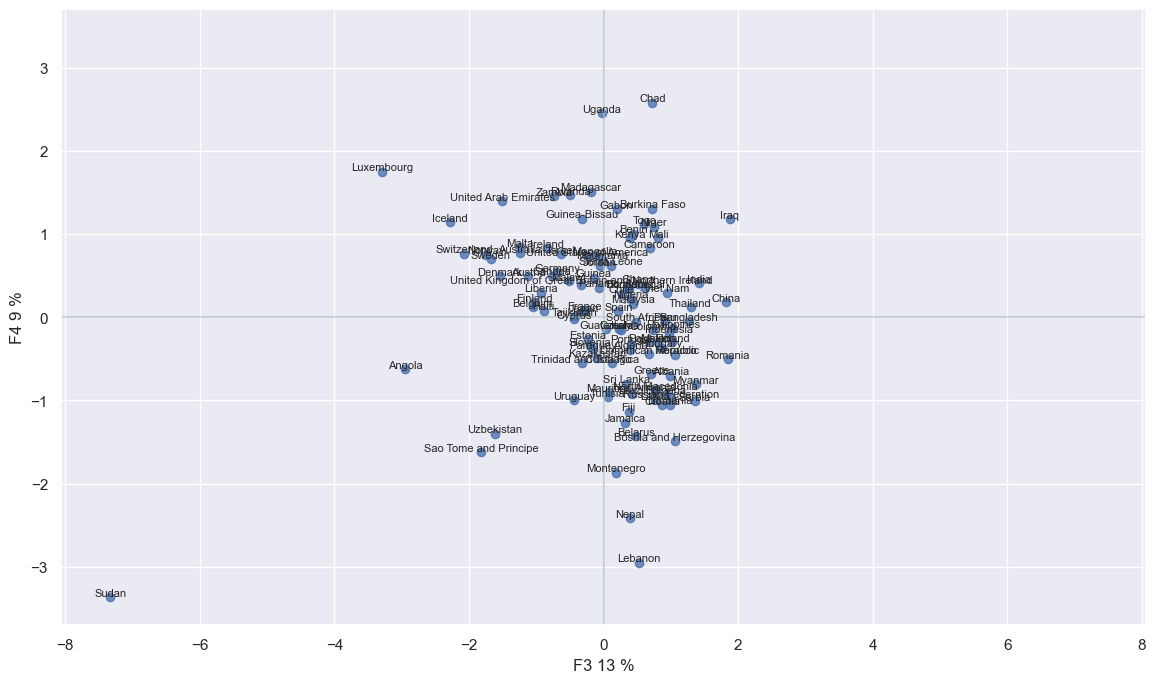

In [12]:
#Component 2/3 representation
axis = [2,3]
display_factorial_planes(val_projection, axis, pca, labels=names, figsize=(14,8), marker="o")

<div style="display: flex; background-color: #0a97b0;" >
<h1 style="margin: auto; padding: 18px; ">Clustering</h1>
</div>

<div style="display: flex; background-color: #5FADE8;" >
<h1 style="margin: auto; padding: 18px; ">Utilisation de K-means</h1>
</div>

N_clusters : 2 -> 0.312
N_clusters : 3 -> 0.315
N_clusters : 4 -> 0.327
N_clusters : 5 -> 0.346
N_clusters : 6 -> 0.316
N_clusters : 7 -> 0.298
N_clusters : 8 -> 0.323
N_clusters : 9 -> 0.273
N_clusters : 10 -> 0.284


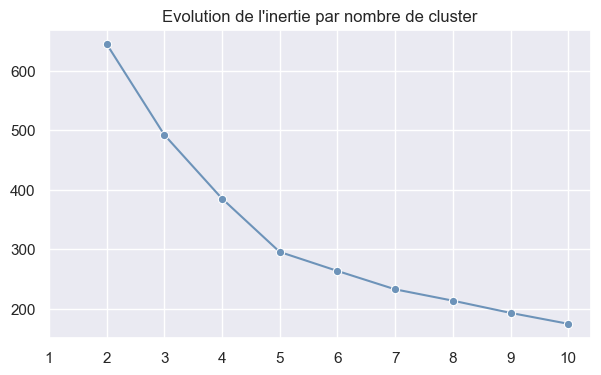

       cluster  percent_change
N1  644.958265             NaN
N2  492.188969        1.310387
N3  385.064592        1.278198
N4  295.382406        1.303614
N5  263.427749        1.121303
N6  232.530623        1.132873
N7  213.487445        1.089200
N8  192.939240        1.106501
N9  174.601219        1.105028


'Using the silhouette score we can see that the number of cluster 5 is the one with the better inter-cluster inertia'

In [13]:
inertia_list = [ ]
# Notre liste de nombres de clusters : 
k_list = range(2, 11)
for k in k_list : 
    # On instancie un k-means pour k clusters
    kmeans = KMeans(n_clusters=k, n_init=50, random_state=4)
    cluster_labels = kmeans.fit_predict(val_projection)
    sil = silhouette_score(val_projection, cluster_labels) #to round
    print(f"N_clusters : {k} ->", round(sil,3))
    # On entraine
    kmeans.fit(val_projection)
    
    # On enregistre l'inertie obtenue en la divisant par 10^15 pour rendre les résultats plus lisibles
    inertia_list.append(kmeans.inertia_)

    
cluster_inertia = pd.DataFrame(inertia_list,columns=["cluster"], index=[f"N{c}" for c in range(1, len(k_list)+1)])
cluster_inertia['percent_change'] = 1/(cluster_inertia['cluster']/cluster_inertia['cluster'].shift(1))

sns.set_theme(rc={'figure.figsize':(7,4)})
cum_cluster = np.cumsum(inertia_list)
ax = sns.lineplot(y=inertia_list, x=k_list, color="#6d93b9", dashes =True, marker="o")
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.title("Evolution de l'inertie par nombre de cluster")
plt.show()
df_exp_var = pd.DataFrame(pca.explained_variance_ratio_)
print(cluster_inertia)
'''Using the silhouette score we can see that the number of cluster 5 is the one with the better inter-cluster inertia'''

In [14]:
#Choosing a cluster number using the previous cluster analysis
n_clusters=4
kmeans = KMeans(n_clusters=n_clusters, random_state=5)

#We train our algorithm to assign values to our number of cluster
kmeans.fit(val_projection)
#We stock our clusters labels into a variable
categ = kmeans.labels_

df_projection = pd.DataFrame(val_projection, columns = ["F1", "F2", "F3", "F4"])
df_projection["kmeans_clusters"] = categ
df_projection.head(5)
clusters_compvalue = df_projection.groupby("kmeans_clusters").agg(F1 =("F1", "mean"), F2 =("F2", "mean"), F3 =("F3", "mean"), F4 =("F4", "mean"))
print(clusters_compvalue.head(10))

'''add column with global average to compare with clusters average for each component'''


                       F1        F2        F3        F4
kmeans_clusters                                        
0                3.032572  0.112165 -0.997366  0.556809
1               -0.455902  1.206299  0.355152 -0.243157
2                0.499467 -1.159744  0.440070 -0.916507
3               -2.569826 -0.535001 -0.094806  0.840256


'add column with global average to compare with clusters average for each component'

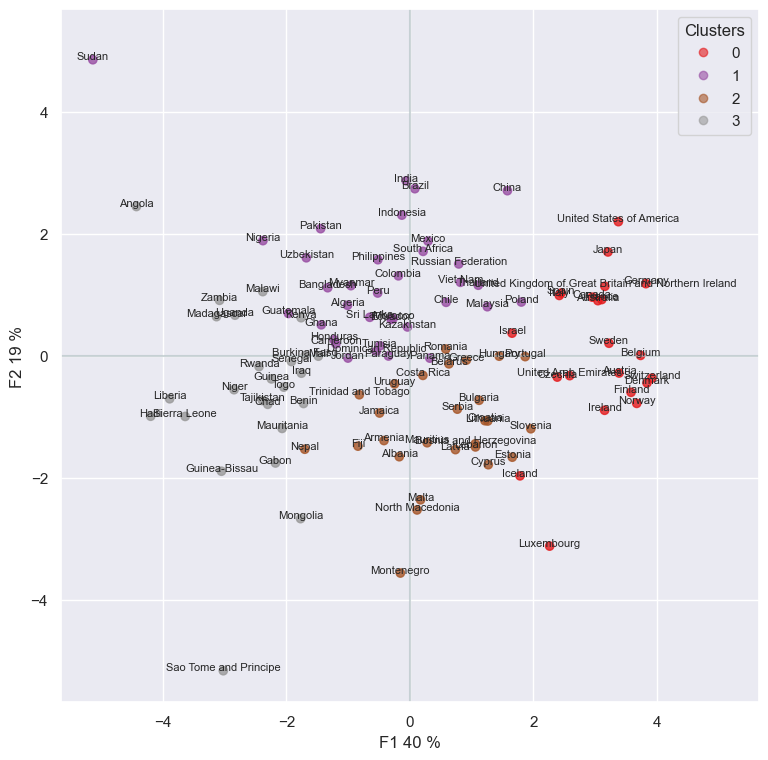

In [15]:
display_factorial_planes(val_projection, [0,1], pca, labels=names, clusters=categ, figsize=(9,9), marker="o")
# display_factorial_planes(val_projection, [2,3], pca, labels=names, clusters=categ, figsize=(12,9), marker="o")

['Australia' 'Austria' 'Belgium' 'Canada' 'Czechia' 'Denmark' 'Finland'
 'France' 'Germany' 'Iceland' 'Ireland' 'Israel' 'Italy' 'Japan'
 'Luxembourg' 'Norway' 'Spain' 'Sweden' 'Switzerland'
 'United Arab Emirates'
 'United Kingdom of Great Britain and Northern Ireland'
 'United States of America']


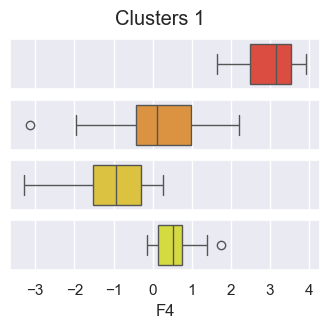

['Algeria' 'Bangladesh' 'Brazil' 'Cameroon' 'Chile' 'China' 'Colombia'
 'Dominican Republic' 'Ecuador' 'Ghana' 'Guatemala' 'Honduras' 'India'
 'Indonesia' 'Jordan' 'Kazakhstan' 'Malaysia' 'Mexico' 'Morocco' 'Myanmar'
 'Nigeria' 'Pakistan' 'Panama' 'Paraguay' 'Peru' 'Philippines' 'Poland'
 'Russian Federation' 'South Africa' 'Sri Lanka' 'Sudan' 'Thailand'
 'Tunisia' 'Uzbekistan' 'Viet Nam']


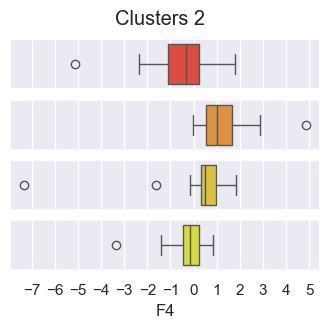

['Albania' 'Armenia' 'Belarus' 'Bosnia and Herzegovina' 'Bulgaria'
 'Costa Rica' 'Croatia' 'Cyprus' 'Estonia' 'Fiji' 'Greece' 'Hungary'
 'Jamaica' 'Latvia' 'Lebanon' 'Lithuania' 'Malta' 'Mauritius' 'Montenegro'
 'Nepal' 'North Macedonia' 'Portugal' 'Romania' 'Serbia' 'Slovenia'
 'Trinidad and Tobago' 'Uruguay']


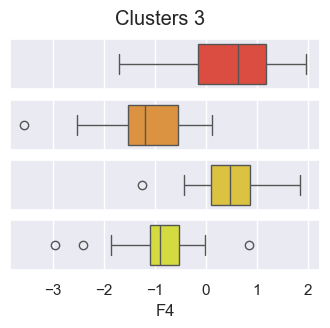

['Angola' 'Benin' 'Burkina Faso' 'Chad' 'Gabon' 'Guinea' 'Guinea-Bissau'
 'Haiti' 'Iraq' 'Kenya' 'Liberia' 'Madagascar' 'Malawi' 'Mali'
 'Mauritania' 'Mongolia' 'Niger' 'Rwanda' 'Sao Tome and Principe'
 'Senegal' 'Sierra Leone' 'Tajikistan' 'Togo' 'Uganda' 'Zambia']


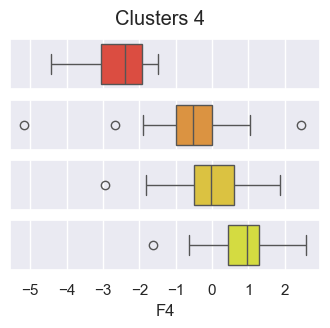

In [16]:
df_projection.index = names
cluster_dict = {}
for cl in range(0,n_clusters):
    # print(f"Clusters_{cl}")
    print(df_projection.loc[df_projection["kmeans_clusters"]==cl].index.unique().values)
    cluster_dict[f"cluster_{cl}"] = df_projection.loc[df_projection["kmeans_clusters"]==cl].index.unique().values
    fig, ax = plt.subplots(nrows=4,sharex=True, figsize =(4, 3))
    plt.suptitle(f"Clusters {cl+1}")
    plt.xticks(range(-8,6))
    sns.boxplot(df_projection.loc[df_projection["kmeans_clusters"] ==cl ,"F1" ], orient="h", color="#F53827", ax=ax[0])
    sns.boxplot(df_projection.loc[df_projection["kmeans_clusters"] ==cl ,"F2" ], orient="h", color="#F59527", ax=ax[1])
    sns.boxplot(df_projection.loc[df_projection["kmeans_clusters"] ==cl ,"F3" ], orient="h", color="#F5D327", ax=ax[2])
    sns.boxplot(df_projection.loc[df_projection["kmeans_clusters"] ==cl ,"F4" ], orient="h", color="#EBF527", ax=ax[3])
    plt.show()

In [17]:
df_projection.index = names
# df_projection["country"] = df_projection.index
df_projection.head()
df_projection.to_csv(f"{path}df_projection.csv")

In [18]:
print(df.loc[df.index.isin(cluster_dict["cluster_0"])].mean())
print(df.loc[df.index.isin(cluster_dict["cluster_1"])].mean())
print(df.loc[df.index.isin(cluster_dict["cluster_2"])].mean())
print(df.loc[df.index.isin(cluster_dict["cluster_3"])].mean())

Production                          2.508276
Annual growth US$ per capita        6.267519
Value US$ per capita            53374.786142
infla_var                           2.988906
Undernourish%                       2.100000
Import_export%                      7.045455
pop_2018                           16.508542
percent_var_pop                     2.815111
Healthy_diet                        0.796048
clearance                           3.635706
logistic_quality                    3.861336
dtype: float64
Production                         2.583188
Annual growth US$ per capita       2.058048
Value US$ per capita            5740.397108
infla_var                         18.101445
Undernourish%                      6.060000
Import_export%                    13.971429
pop_2018                          17.693946
percent_var_pop                    4.352086
Healthy_diet                       0.922365
clearance                          2.579154
logistic_quality                   2.789688
dtype:

<div style="display: flex; background-color: #5FADE8;" >
<h1 style="margin: auto; padding: 18px; ">Utilisation de la classification Ascendante Hierachique</h1>
</div>

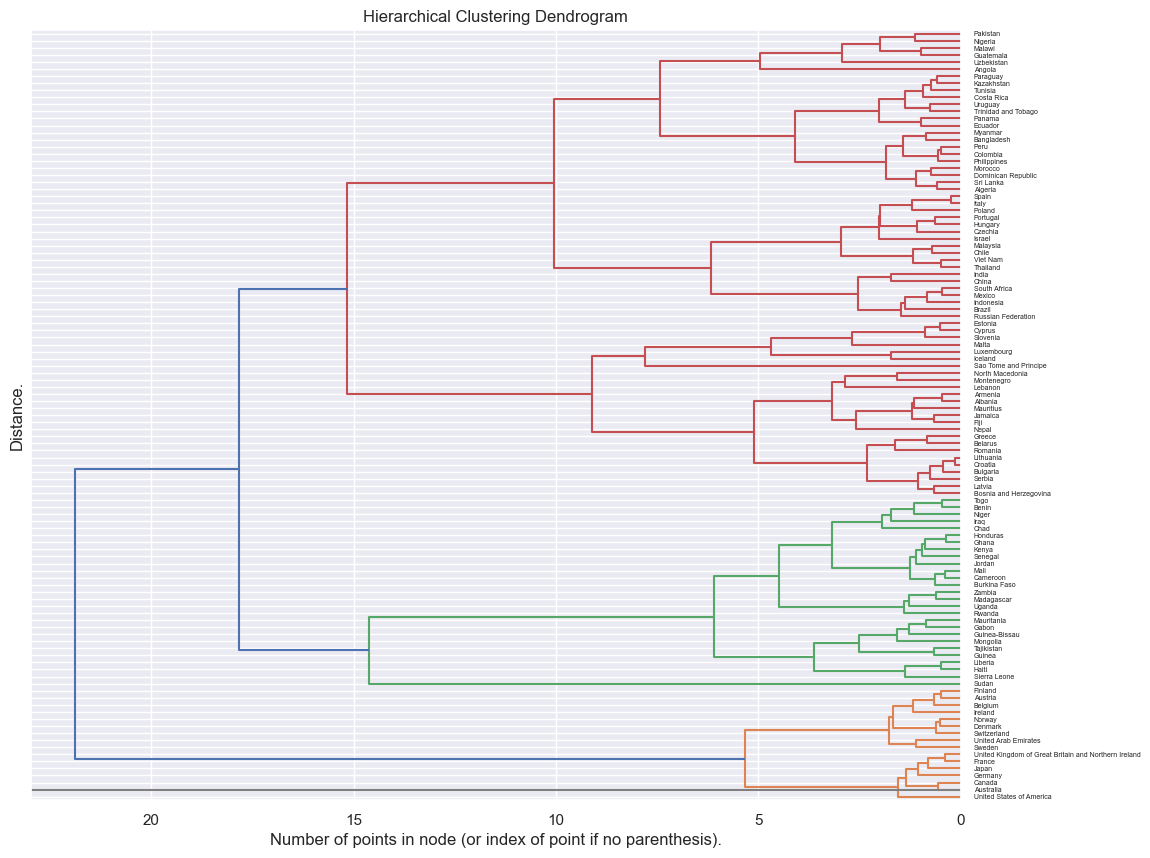

In [19]:
#distance between point display
df_cah = df_projection.copy()
df_cah = df_cah.filter(items=["F1", "F2", "F3", "F4"])
Z = linkage(df_cah, method="ward")
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
_ = dendrogram(Z, p=10, labels = df_cah.index, ax=ax, orientation="left")
# _ = dendrogram(Z, p=10, ax=ax, orientation="top")

plt.title("Hierarchical Clustering Dendrogram")
plt.axhline(15, color="gray")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Distance.")
plt.show()

In [20]:
#Retrieving the labels of the clusters for the CAH methods
agg_cluster = AgglomerativeClustering(n_clusters= 4)
agg_cluster.fit(df_cah)
df_cah["cah_clusters"] = agg_cluster.labels_
#Creating a df with both clusters labels to compare them
df_clusters = pd.merge(df_cah, df_projection, on ="country", how="inner")

In [21]:
#We can see a few differences for some labels but for what is about the components values by clusters, we will be close to the kmeans method
df_clusters = df_clusters.filter(items=["F1", "F2", "F3", "F4","kmeans_clusters", "cah_clusters"])
df_clusters.sort_values("kmeans_clusters", inplace=True)
print(df_clusters.head(10))

            kmeans_clusters  cah_clusters
country                                  
Austria                   0             3
Australia                 0             3
Canada                    0             3
Belgium                   0             3
Denmark                   0             3
Finland                   0             3
France                    0             3
Czechia                   0             2
Iceland                   0             1
Luxembourg                0             1


In [22]:
#Calculating the silhouette score for the CAH methods
sil_list =[]
for c in range(2,10) : #We calculate the silhouette score for the cluster create with the CAH
    agg_cluster = AgglomerativeClustering(n_clusters= c, compute_distances=True)
    agg_cluster.fit(df_cah)
    sil = silhouette_score(val_projection, agg_cluster.labels_)
    sil_list.append(sil)
df_sil = pd.DataFrame({"cluster":range(2,10), "silhouette":sil_list})
print(df_sil)
'''We can also see that on this method the highest silhouette score is for 5 clusters'''

   cluster  silhouette
0        2    0.273510
1        3    0.261113
2        4    0.282307
3        5    0.294533
4        6    0.255093
5        7    0.271384
6        8    0.275072
7        9    0.259977


'We can also see that on this method the highest silhouette score is for 5 clusters'